In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect
#from sqlalchemy import create_engine, inspect, func

In [9]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [10]:
# reflect an existing database into a new model

# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [17]:
Base = automap_base()
Base.prepare(engine, reflect=True)


In [18]:
# We can view all of the classes that automap found
Measurement = Base.classes.measurement
Station = Base.classes.station


In [19]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [20]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [21]:
# Save references to each table
session = Session(engine)

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date


('2017-08-23')

In [24]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago=dt.date(2017, 8, 23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [25]:
#Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

#Save the query results as a Pandas DataFrame 
prcp_data_df = pd.DataFrame(prcp_data)
prcp_data_df.head()

#set the index to the date column
prcp_data_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


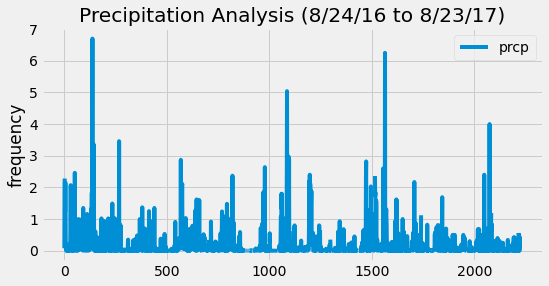

In [140]:
#Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_data_df.plot(figsize=(8,4))
ax.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
ax.set_ylabel('frequency')
plt.show()





In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [27]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?

stations_active = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_active


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
#Using the station id from the previous query
most_active_station = stations_active[0][0]
most_active_station


'USC00519281'

In [30]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_recorded=session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

In [31]:
temp_recorded

[(85.0, 54.0, 71.66378066378067)]

In [32]:
## Choose the station with the highest number of temperature observations.
station_most_tempstats = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
station_most_tempstats = station_most_tempstats[0]
station_most_tempstats

'USC00519281'

In [33]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > one_year_ago).\
    filter(Measurement.station==station_most_tempstats)
    
temp_data_df = pd.DataFrame(temp_data)
temp_data_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


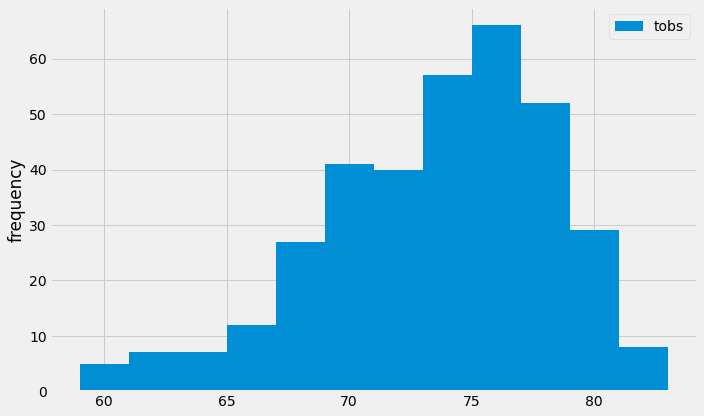

<Figure size 432x288 with 0 Axes>

In [38]:
plt.figure(figsize=(10,6))
plt.hist(temp_data_df["tobs"], bins=12)
plt.ylabel("frequency")
plt.legend(["tobs"])
plt.tight_layout()
plt.show()

# Save the plot
# plt.tight_layout()
plt.savefig("../sqlalchemy-challenge/frequecy.png")
plt.show()

## Bonus Challenge Assignment

In [167]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [36]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-28', '2017-03-05'))
temp=(calc_temps('2017-02-28', '2017-03-05'))
temp

[(64.0, 72.02777777777777, 78.0)]


[(64.0, 72.02777777777777, 78.0)]

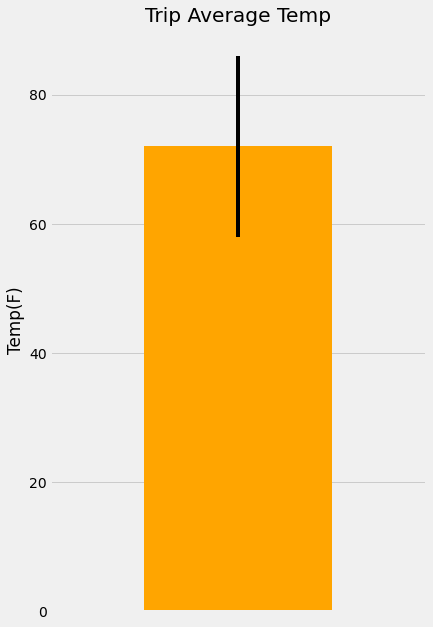

<Figure size 432x288 with 0 Axes>

In [37]:
# Plot the results from your previous query as a bar chart. 


df = pd.DataFrame(temp ,columns=['t-min','t-avg','t-max'])
df.head()



# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# plot the average temp 
plt.figure(figsize=(6,10))
ax=df["t-avg"].plot.bar(yerr=(df["t-max"]-df["t-min"]), color="orange")
plt.title("Trip Average Temp")
plt.ylabel("Temp(F)")
ax.axes.get_xaxis().set_visible(False)
plt.show()

# Save the plot
plt.tight_layout()
plt.savefig("../sqlalchemy-challenge/avg_temp.png")
plt.show()


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
